# Convert dataset to supervisely format
More info could be found at:
* [import-images-in-sly-format](https://app.supervisely.com/ecosystem/apps/import-images-in-sly-format?id=154)
* [project structure inside Supervisely](https://docs.supervisely.com/customization-and-integration/00_ann_format_navi/01_project_structure_new)

Project structure to follow:

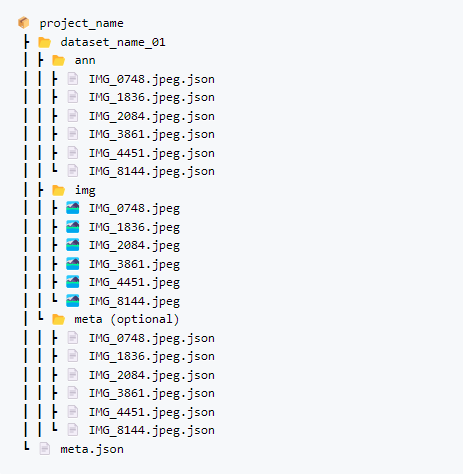

## Code function:
- Looping in the Github repo dataset
- copying images in the "img" folder
- copying annotations in the"ann" folder:
    - deleting possible "tag" remained from old annotations jobs 
    - fixing wrong ClassTitle id for the TennisOurY5L class due to old code-based json file annotations modifications
    - collecting all Class titles and info to populate the meta.json project file
- create the meta.json project file.

The created **"to_upload_project"** folder can be directly uploaded to supervisely using the [Import images in supervisely format](https://app.supervise.ly/ecosystem/apps/import-images-in-sly-format?id=154) app

In [1]:
import os
import shutil
import json
import random

In [3]:
print(os.getcwd())
os.chdir(r"../")
print(os.getcwd())

/media/mirko/Volume/GITHUB/OpenAcces_RGBD_apple_dataset/notebook
/media/mirko/Volume/GITHUB/OpenAcces_RGBD_apple_dataset


sistema labels problema TB

In [121]:
from datetime import datetime


# looping in each dir of the dataset 
for cam_obj_distance in os.listdir(os.path.join(os.getcwd(), 'dataset')):
    for point_of_view in os.listdir(os.path.join(os.getcwd(), f'dataset/{cam_obj_distance}')):
        for date in os.listdir(os.path.join(os.getcwd(), f'dataset/{cam_obj_distance}/{point_of_view}')):
            for file in os.listdir(os.path.join(os.getcwd(), f'dataset/{cam_obj_distance}/{point_of_view}/{date}')):
                    
                    if file.endswith('.png'):
                        # making images "img" dir for supervisely format 
                        os.makedirs(os.path.join(os.getcwd(), f"dataset_modified/{cam_obj_distance}/{point_of_view}/{date}"), exist_ok= True)
                        current_name = os.path.join(os.getcwd(), f'dataset/{cam_obj_distance}/{point_of_view}/{date}/{file}')
                        new_name = os.path.join(os.getcwd(), f'dataset_modified/{cam_obj_distance}/{point_of_view}/{date}/{file}')

                        # copy images to the img  directory 
                        shutil.copyfile(current_name , new_name )
                      
                    if file.endswith('.json'):
                        # making annontations "ann" dir for supervisely format 
                        os.makedirs(os.path.join(os.getcwd(), f"dataset_modified/{cam_obj_distance}/{point_of_view}/{date}/"), exist_ok= True)
                        current_name = os.path.join(os.getcwd(), f'dataset/{cam_obj_distance}/{point_of_view}/{date}/{file}')
                        new_name = os.path.join(os.getcwd(), f'dataset_modified/{cam_obj_distance}/{point_of_view}/{date}/{file}')

                        # Read the annotation file
                        with open(current_name) as json_file:
                            json_label = json.load(json_file)

                        # check data to remove unwanted data (such as private info)
                        json_label['description'] = 'Bortolotti, G., Piani, M., Gullino, M., Franceschini, C., Mengoli, D., & Manfrini, L. (2024). OpenAcces_RGBD_apple_dataset (Version 1.2.0)'

                        if len(json_label['tags']) > 0:
                            for index, item in enumerate(json_label['tags']): # item is a list
                                for k in item:
                                    if k == 'labelerLogin':
                                        # overwrite info
                                        json_label['tags'][index][k] = 'Human_Labeller'
                                    
                                    if k == 'updatedAt':
                                        # change to current datetime
                                        json_label['tags'][index][k] = datetime.now().isoformat()  # ISO 8601

              
                        if len(json_label['objects']) > 0:
                            for index, item in enumerate(json_label['objects']): # item is a list
                                for k in item:

                                    # update time of last update
                                    if k == 'updatedAt':
                                        # change to current datetime
                                        json_label['objects'][index][k] = datetime.now().isoformat()  # ISO 8601

                                    # change label class names
                                    if k == 'classTitle':
                                        # change to standard yolov5 detection bounding box
                                        if json_label['objects'][index][k] == 'Apple_Y5L':
                                            json_label['objects'][index][k] = 'apple_Y5L_std_bbox'
                                        
                                        elif json_label['objects'][index][k] == 'Tennis_Y5L':
                                            json_label['objects'][index][k] = 'TB_Y5L_std_bbox'

                                        # change to trained yolov5 detection bounding box
                                        elif json_label['objects'][index][k] == 'Apple_ourY5L':
                                            json_label['objects'][index][k] = 'apple_Y5L_trained_bbox'

                                        elif json_label['objects'][index][k] == 'Tennis_ourY5L':
                                            json_label['objects'][index][k] = 'TB_Y5L_trained_bbox'
                                            json_label['objects'][index]['classId'] = 11280287

                                        # change to manual annotation
                                        elif json_label['objects'][index][k] == 'Apple_Man':
                                            json_label['objects'][index][k] = 'apple_manual_annot'

                                        elif json_label['objects'][index][k] == 'Tennis_Man':
                                            json_label['objects'][index][k] = 'TB_manual_annot'
                                    
                                    # adjust description to remove typos "\n"
                                    if k == 'description':
                                        if json_label['objects'][index][k] != '':
                                            json_label['objects'][index][k] = str(int(json_label['objects'][index][k]))
                                    
                                    # add description to Tennisballs
                                    if json_label['objects'][index]['classTitle'].find('TB_') != -1: 
                                            json_label['objects'][index]['description'] = str('TB')
                                    
                                    # hide private info
                                    if json_label['objects'][index]['classTitle'].find('Y5L_std') != -1:
                                        json_label['objects'][index]['labelerLogin'] = 'Item annotated with a YOLOv5l standard model from ultralytics'
                                    
                                    if json_label['objects'][index]['classTitle'].find('Y5L_trained') != -1:
                                        json_label['objects'][index]['labelerLogin'] = 'Item annotated with a YOLOv5l model from ultralytics trained on a custom dataset'
                                    
                                    if json_label['objects'][index]['classTitle'].find('manual') != -1:
                                        json_label['objects'][index]['labelerLogin'] = 'Manually annotated'
                           
                        # Write the modified JSON to the new file with indentation for readability
                        with open(new_name, 'w') as new_json_file:
                            json.dump(json_label, new_json_file, indent=4)